# Resolution and Contrast Evaluation

This notebook provides the code for the resolution evaluation on a PICMUS real world data-set. Furthermore, there is the contrast evaluation of a circular echoic region.

The notebook is layed out in a way that two beamformers are applied to the same data and evaluated using the same metrics. It is recommended to leave the first beamformer as a DAS beamformer to have a baseline and use the beamformer class one wants to scrutinize as the second one.

In [47]:
# Import PyBF library
import numpy as np
import sys, os
import h5py
'''
import sys, os
look here if below import doesn't work: https://stackoverflow.com/questions/7505988/importing-from-a-relative-path-in-python
'''
# sys.path.append('../jupyter')
sys.path.append('.')
from pybf.pybf.io_interfaces import DataLoader
from pybf.scripts.beamformer_DAS_ref import BFCartesianReference
from pybf.scripts.beamformer_mvbf_spatial_smooth import BFMVBFspatial
from pybf.scripts.beamformer_mvbf_DCR import BFMVBFdcr
from pybf.pybf.image_settings import ImageSettings
from pybf.pybf.visualization import plot_image
from pybf.scripts.picmus_eval import PicmusEval

%matplotlib ipympl

### Import data

In [2]:
data_loader_obj = DataLoader('./pybf/tests/data/Picmus/resolution_distorsion/rf_dataset.hdf5')

In [3]:
tx_temp = data_loader_obj.tx_strategy
tx_temp

('PW_75_16',
 array([-0.27925268, -0.2717053 , -0.26415795, -0.25661057, -0.24906321,
        -0.24151583, -0.23396847, -0.22642109, -0.21887372, -0.21132635,
        -0.20377898, -0.19623162, -0.18868424, -0.18113688, -0.1735895 ,
        -0.16604213, -0.15849477, -0.15094739, -0.14340003, -0.13585265,
        -0.12830529, -0.12075792, -0.11321054, -0.10566317, -0.09811581,
        -0.09056844, -0.08302107, -0.0754737 , -0.06792632, -0.06037896,
        -0.05283159, -0.04528422, -0.03773685, -0.03018948, -0.02264211,
        -0.01509474, -0.00754737,  0.        ,  0.00754737,  0.01509474,
         0.02264211,  0.03018948,  0.03773685,  0.04528422,  0.05283159,
         0.06037896,  0.06792632,  0.0754737 ,  0.08302107,  0.09056844,
         0.09811581,  0.10566317,  0.11321054,  0.12075792,  0.12830529,
         0.13585265,  0.14340003,  0.15094739,  0.15849477,  0.16604213,
         0.1735895 ,  0.18113688,  0.18868424,  0.19623162,  0.20377898,
         0.21132635,  0.21887372,  0.2

 ### Image settings
  
For some beamformers evaluated in the project, the tx_strategy needs to be set up in a way that at least two plane waves need to be emitted from different angles.

 ## Instantiate beamformers

(Copied from the PyBF code comments)

### `active_elements`
- sets the active elements of the transducer by list of indices
- Attention: elements numeration starts from 0

### `channel_reduction`

- channel reduction is the number of channels to be used for beamforming

Code snipped from `beamformer_DAS_ref.py`

```python
ch_nr = n_elements
start_i = int(np.ceil((ch_nr - channel_reduction)/2))
stop_i = int(start_i + channel_reduction)
```

In [4]:
def create_beamformer(tx_strategy_indices, img_config):

    ### Specify preprocessing parameters for RF data ###
    decimation_factor = 1
    interpolation_factor = 10

    ### Specify TX strategy and Apodization parameters ###
    start_time = 0
    correction_time_shift = 0

    alpha_fov_apod = 40

    tx_strategy = [[],[]]
    # take tx_strategy and outputs a list with all the angles we want to use
    # data_loader.tx_strategy[1] are the angles
    # our tx_strategy_indices is a list of 2 elements: the first is the name of the strategy, the second is the list of angles
        # tx_strategy_indices = ['PW_name', [30, 40, 50, 60]]
    # we want to return an list with ['PW_name', [data_loader_obj.tx_strategy[1][30], ...]]
    all_angles = data_loader_obj.tx_strategy[1]
    # slice all_angles with indices in tx_strategy_indices to get the correct angles
    tx_strategy[0] = tx_strategy_indices[0]
    tx_strategy[1] = all_angles[tx_strategy_indices[1]]
    print(tx_strategy)

    # tx_strategy = ['PW_4_2.2', [data_loader_obj.tx_strategy[1][angle_indices[0]], data_loader_obj.tx_strategy[1][angle_indices[1]], data_loader_obj.tx_strategy[1][angle_indices[2]], data_loader_obj.tx_strategy[1][angle_indices[3]] ]]
    # tx_strategy = ['PW_75_16', data_loader_obj.tx_strategy[1]]
    # tx_strategy = ['PW_4_2.1', [data_loader_obj.tx_strategy[1][33], data_loader_obj.tx_strategy[1][37], data_loader_obj.tx_strategy[1][38], data_loader_obj.tx_strategy[1][42]]]
    # tx_strategy = ['PW_2_2', [data_loader_obj.tx_strategy[1][0], data_loader_obj.tx_strategy[1][1]]]
    rf_data_shape = (len(tx_strategy[1]),) + data_loader_obj.get_rf_data(0, 0).shape
    rf_data = np.zeros(rf_data_shape)
    inclin_index = np.asarray(tx_strategy_indices[1])
    for i in range(rf_data.shape[0]):
        rf_data[i, :, :] = data_loader_obj.get_rf_data(0, inclin_index[i])

    SAMPLING_FREQ = data_loader_obj.f_sampling

    filters_params = [1 * 10 **6, 8 * 10 **6, 0.5 * 10 **6]

    bf = BFCartesianReference(SAMPLING_FREQ,
                                tx_strategy,
                                data_loader_obj.transducer,
                                decimation_factor,
                                interpolation_factor,
                                img_res,
                                img_config,
                                start_time=start_time,
                                correction_time_shift=correction_time_shift,
                                alpha_fov_apod=alpha_fov_apod,
                                bp_filter_params=filters_params,
                                envelope_detector='I_Q',
                                picmus_dataset=True,
                                channel_reduction=128)
    
    return bf, rf_data

In [5]:
def perform_beamforming(tx_strategy, transducer_indices):
    bf, rf_data = create_beamformer(tx_strategy)

    # set active transducer elements
    # indices = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]
    sliced_rf_data = rf_data[:, transducer_indices, :]

    img_data = bf.beamform(sliced_rf_data, numba_active=False)

    return img_data

In [6]:
tx_strategy_indices = ['PW_4_2.1', [33, 37, 38, 42]]

n = 16
transducer_indices = [i for i in range(0, 128, n)]
print(transducer_indices)

# img_data = perform_beamforming(tx_strategy_indices, transducer_indices)

[0, 16, 32, 48, 64, 80, 96, 112]


In [7]:
img_res = [400, 600]
image_x_range = [-0.019, 0.019]
image_z_range = [0.005, 0.05]

db_range = 50

LATERAL_PIXEL_DENSITY_DEFAULT = 5

img_config = ImageSettings( image_x_range[0],
                            image_x_range[1],
                            image_z_range[0],
                            image_z_range[1],
                            LATERAL_PIXEL_DENSITY_DEFAULT,
                            data_loader_obj.transducer)


The highest resolution for the system is:  (633, 205)


In [8]:
channel_reduction = 128
# active_elements = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
active_elements = np.arange(128)
angle_indices = [33, 37, 38, 45]
tx_strategy_indices = ['PW_4_2', angle_indices]
# angle_indices = list(range(75))

print(data_loader_obj.transducer.set_active_elements(active_elements))
print(data_loader_obj.transducer.active_elements)

Transducer: number of active elements =  128
None
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127]


In [9]:
bf, rf_data = create_beamformer(tx_strategy_indices, img_config)

['PW_4_2', array([-0.03018948,  0.        ,  0.00754737,  0.06037896], dtype=float32)]
Delays precalculation...
TX strategy: plane waves
Number of plane waves:  4
Maximum angle:  2.0 °
Apodization precalculation...


 ## Beamform
 
 Performs the beamforming for the whole image
 
 **Note:** This part of the code is by far the most computationally expensive step. Beamforming using a MVBF beamformer can take several minutes (up to approx. 20 minutes) if a high number of channels is used!

In [10]:
trunkated_data = rf_data[:,active_elements,:]
print(trunkated_data.shape)
# beamformer 1
print("Img Data for Beamformer 1")
img_data = bf.beamform(trunkated_data, numba_active=False)

(4, 128, 3328)
Img Data for Beamformer 1
Beamforming...
 
[]
[array([[-8.4257806e-03-6.6253804e-03j,  1.1755430e-02-1.3562265e-03j,
         2.5624097e-03+8.4099835e-03j, ...,
        -9.1385590e-03+1.1677770e-02j,  4.1864943e-03+1.0834026e-02j,
         6.0159555e-03-7.2599913e-05j],
       [-8.4257806e-03-6.6253804e-03j,  1.1368384e-02-3.1767131e-03j,
         5.0993063e-03+7.2945631e-03j, ...,
         1.2713672e-02+1.2119113e-03j,  7.8517366e-03-1.0385554e-02j,
        -4.5965072e-03-8.7868338e-03j],
       [-8.4257806e-03-6.6253804e-03j,  1.0691234e-02-4.9071647e-03j,
         6.1985501e-03+6.4540734e-03j, ...,
        -2.5812311e-03-9.2560835e-03j, -1.2409699e-02-5.3541106e-03j,
        -8.4864935e-03+1.0675677e-02j],
       ...,
       [ 1.0425742e-03+1.3297106e-04j,  2.6889477e-04-2.4328794e-04j,
        -1.1674691e-04-5.7192874e-04j, ...,
         3.1468034e-04-1.3258462e-04j, -1.3714157e-03-1.3079593e-03j,
        -9.2170085e-04+1.3933521e-03j],
       [ 4.5417692e-04+9.41191

## Evaluations and Visualize

For both beamformers the Full-Width at Half-Maximum (FWHM) metric is calculated for a number of predefined scatterers in the test data in meters.

BF Final dB range (-50.0,0.0)


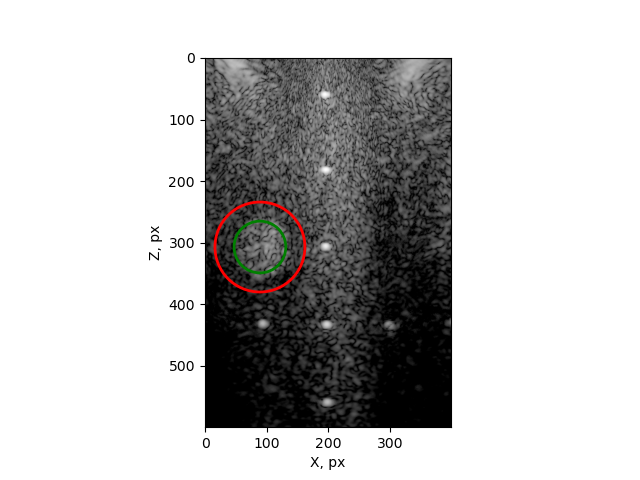

BF Final dB range (-50.0,0.0)


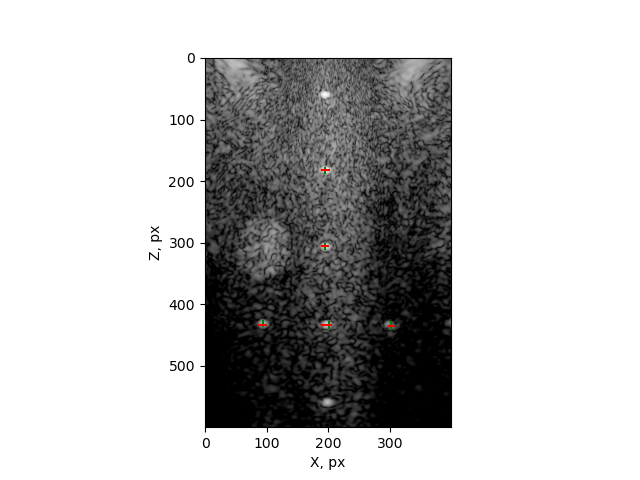

CNR values are [dB]:
[5.4879547]

x-axis FWHM values are [m]:
[0.00104762 0.00095238 0.00133333 0.00104762 0.0007619 ]
z-axis FWHM values are [m]:
[0.00067613 0.00067613 0.00067613 0.00067613 0.00082638]
BF Final dB range (-50.0,0.0)


c:\Vault\Documents\_RealLifeFolder\_School\_ETH\Bachelor of Science\7. Semester\P&S\Wearable Ultrasound\Beamforming\juypter\pybf\pybf\visualization.py:170: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



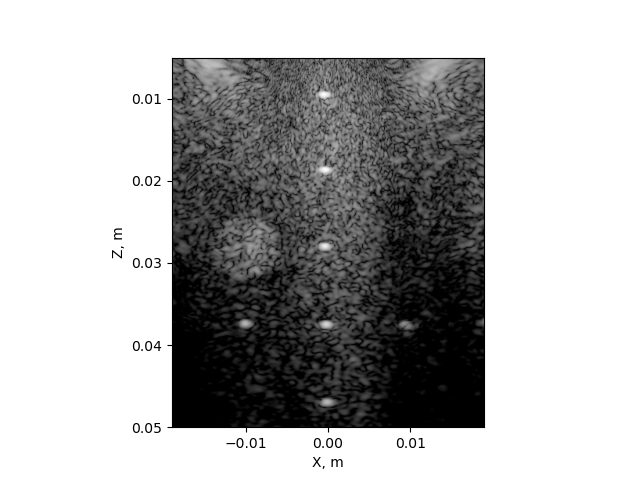

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='X, m', ylabel='Z, m'>)

In [17]:
eval_obj = PicmusEval(img_data, bf)
circle_pos = np.asarray([[-0.0105, 0.0281, 0.007, 0.004]])
CNR_values = eval_obj.evaluate_circ_contrast(circle_pos)

scatterer_pos = np.asarray([[-0.001, 0.018, 0.001, 0.001],
                            [-0.001, 0.0277, 0.001, 0.001],
                            [0.0001, 0.0375, 0.001, 0.001],
                           [-0.0104, 0.0375, 0.001, 0.001],
                           [0.0095, 0.0375, 0.001, 0.001]])
FWHM_x, FWHM_y = eval_obj.evaluate_FWHM(scatterer_pos,is_plot=True, 
                                        plot_name="ultrasound_images/FWHM_eval")

print("CNR values are [dB]:")
print(str(CNR_values) + "\n")
print("x-axis FWHM values are [m]:")
print(str(FWHM_x))
print("z-axis FWHM values are [m]:")
print(str(FWHM_y))

image_path = './ultrasound_images/'
image_title = 'DAS'
# visualize DAS image
plot_image(np.abs(img_data), 
               scatters_coords_xz=None,
               elements_coords_xz=None,
               framework='matplotlib',
               title=image_title,
               image_x_range=image_x_range,
               image_z_range=image_z_range,
               db_range=db_range,
               colorscale='Greys',
               save_fig=True, 
               show=True,
               path_to_save=image_path)


In [ ]:
# all imports


Defining all functions

In [ ]:
def create_beamformer(tx_strategy_indices, img_config):

    ### Specify preprocessing parameters for RF data ###
    decimation_factor = 1
    interpolation_factor = 10

    ### Specify TX strategy and Apodization parameters ###
    start_time = 0
    correction_time_shift = 0

    alpha_fov_apod = 40

    tx_strategy = [[],[]]
    # take tx_strategy and outputs a list with all the angles we want to use
    # data_loader.tx_strategy[1] are the angles
    # our tx_strategy_indices is a list of 2 elements: the first is the name of the strategy, the second is the list of angles
        # tx_strategy_indices = ['PW_name', [30, 40, 50, 60]]
    # we want to return an list with ['PW_name', [data_loader_obj.tx_strategy[1][30], ...]]
    all_angles = data_loader_obj.tx_strategy[1]
    # slice all_angles with indices in tx_strategy_indices to get the correct angles
    tx_strategy[0] = tx_strategy_indices[0]
    tx_strategy[1] = all_angles[tx_strategy_indices[1]]
    print(tx_strategy)

    # tx_strategy = ['PW_4_2.2', [data_loader_obj.tx_strategy[1][angle_indices[0]], data_loader_obj.tx_strategy[1][angle_indices[1]], data_loader_obj.tx_strategy[1][angle_indices[2]], data_loader_obj.tx_strategy[1][angle_indices[3]] ]]
    # tx_strategy = ['PW_75_16', data_loader_obj.tx_strategy[1]]
    # tx_strategy = ['PW_4_2.1', [data_loader_obj.tx_strategy[1][33], data_loader_obj.tx_strategy[1][37], data_loader_obj.tx_strategy[1][38], data_loader_obj.tx_strategy[1][42]]]
    # tx_strategy = ['PW_2_2', [data_loader_obj.tx_strategy[1][0], data_loader_obj.tx_strategy[1][1]]]
    rf_data_shape = (len(tx_strategy[1]),) + data_loader_obj.get_rf_data(0, 0).shape
    rf_data = np.zeros(rf_data_shape)
    inclin_index = np.asarray(tx_strategy_indices[1])
    for i in range(rf_data.shape[0]):
        rf_data[i, :, :] = data_loader_obj.get_rf_data(0, inclin_index[i])

    SAMPLING_FREQ = data_loader_obj.f_sampling

    filters_params = [1 * 10 **6, 8 * 10 **6, 0.5 * 10 **6]

    bf = BFCartesianReference(SAMPLING_FREQ,
                                tx_strategy,
                                data_loader_obj.transducer,
                                decimation_factor,
                                interpolation_factor,
                                img_res,
                                img_config,
                                start_time=start_time,
                                correction_time_shift=correction_time_shift,
                                alpha_fov_apod=alpha_fov_apod,
                                bp_filter_params=filters_params,
                                envelope_detector='I_Q',
                                picmus_dataset=True,
                                channel_reduction=128)
    
    return bf, rf_data

In [ ]:
def perform_beamforming(tx_strategy, transducer_indices):
    bf, rf_data = create_beamformer(tx_strategy)

    # set active transducer elements
    # indices = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]
    sliced_rf_data = rf_data[:, transducer_indices, :]

    img_data = bf.beamform(sliced_rf_data, numba_active=False)

    return img_data

Immuntable Variables

In [46]:
# immunatble variables

# below code generates list containting names of all versions of the images
# under each plane wave angle (folder) will be the range of different transducer counts

every_nth = ['2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th']
percent_from = [90, 80, 70, 60, 50, 40, 30, 20, 10]

# Trials using different count of transducers
transducer_trials_names = ['full']

# For loop to concatenate each string with the suffix
for string in every_nth:
    concatenated_string = 'every ' + string
    transducer_trials_names.append(concatenated_string)

for percent in percent_from:
    concatenated_string = str(percent) + '% from middle'
    transducer_trials_names.append(concatenated_string)

# Print the concatenated strings
print(transducer_trials_names)
print(len(transducer_trials_names))

# Trials using different amounts of plane wave angles
angle_trials_names = ['100% of plane wave angles']

for percent in percent_from:
    concatenated_string = str(percent) + '% of angles'
    angle_trials_names.append(concatenated_string)

# Print the concatenated strings
print(angle_trials_names)
print(len(angle_trials_names))

# generate numerical vectors that go with the names
# must be lists

# full
transducer_trials_values = [[i for i in range(128)]]
# every nth
for i in range(2, 11):
    transducer_trials_values.append([j for j in range(0, 128, i)])
# percent from middle
for i in range(90, 0, -10):
    ch_nr = round(128 * (i / 100.0))
    start_i = int(np.ceil((128 - ch_nr)/2))
    stop_i = int(start_i + ch_nr)
    transducer_trials_values.append([j for j in range(start_i, stop_i)])

# ch_nr = round(128 * (i / 10.0))
# start_i = int(np.ceil((ch_nr - channel_reduction)/2))
# stop_i = int(start_i + channel_reduction)

print(transducer_trials_values)
print(len(transducer_trials_values))

index = 6
print(transducer_trials_names[index])
print(transducer_trials_values[index])

angle_trials_values = []

# percent from middle
for i in range(100, 0, -10):
    ch_nr = round(75 * (i / 100.0))
    start_i = int(np.ceil((75 - ch_nr)/2))
    stop_i = int(start_i + ch_nr)
    angle_trials_values.append([j for j in range(start_i, stop_i)])

print(angle_trials_values)
print(len(angle_trials_values))

['full', 'every 2nd', 'every 3rd', 'every 4th', 'every 5th', 'every 6th', 'every 7th', 'every 8th', 'every 9th', 'every 10th', '90% from middle', '80% from middle', '70% from middle', '60% from middle', '50% from middle', '40% from middle', '30% from middle', '20% from middle', '10% from middle']
19
['100% of plane wave angles', '90% of angles', '80% of angles', '70% of angles', '60% of angles', '50% of angles', '40% of angles', '30% of angles', '20% of angles', '10% of angles']
10
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 1

For Loops that generate all the data

In [54]:
# for loops
for j, angle_trial_name in enumerate(angle_trials_names):
    for i, transducer_trial_name in enumerate(transducer_trials_names):
        # create folder for each trial
        # create folder for each angle
        # create folder for each transducer count
        # create folder for each image
        # save image in the correct folder
        

        


        # Open the image database with write tags
        # 'w' overwrites the file
        # 'a' appends to the file
        with h5py.File('beamforming_image_database.hdf5', 'a') as f:
            # open angle trial data group
            if angle_trial_name not in f:
                angle_grp = f.create_group(angle_trial_name)
            else:
                angle_grp = f[angle_trial_name]
            # open transducer trial data group
            if transducer_trial_name not in angle_grp:
                trial_grp = angle_grp.create_group(transducer_trial_name)
            else:
                trial_grp = angle_grp[transducer_trial_name]

            print(transducer_trial_name)
            # save the values into the datasets
            if 'image' in trial_grp:
                del trial_grp['image']
            trial_grp.create_dataset('image', data='img_data')

            if 'CNR' in trial_grp:
                del trial_grp['CNR']
            trial_grp.create_dataset('CNR', data='CNR_values')

            if 'FWHM_x' in trial_grp:
                del trial_grp['FWHM_x']
            trial_grp.create_dataset('FWHM_x', data='FWHM_x')

            if 'FWHM_y' in trial_grp:
                del trial_grp['FWHM_y']
            trial_grp.create_dataset('FWHM_y', data='FWHM_y')

        



full
every 2nd
every 3rd
every 4th
every 5th
every 6th
every 7th
every 8th
every 9th
every 10th
90% from middle
80% from middle
70% from middle
60% from middle
50% from middle
40% from middle
30% from middle
20% from middle
10% from middle
full
every 2nd
every 3rd
every 4th
every 5th
every 6th
every 7th
every 8th
every 9th
every 10th
90% from middle
80% from middle
70% from middle
60% from middle
50% from middle
40% from middle
30% from middle
20% from middle
10% from middle
full
every 2nd
every 3rd
every 4th
every 5th
every 6th
every 7th
every 8th
every 9th
every 10th
90% from middle
80% from middle
70% from middle
60% from middle
50% from middle
40% from middle
30% from middle
20% from middle
10% from middle
full
every 2nd
every 3rd
every 4th
every 5th
every 6th
every 7th
every 8th
every 9th
every 10th
90% from middle
80% from middle
70% from middle
60% from middle
50% from middle
40% from middle
30% from middle
20% from middle
10% from middle
full
every 2nd
every 3rd
every 4th
every